#SETTING UP DATASET USING KAGGLE API


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
# create a directory named '/.kaggle'
!mkdir ~/.kaggle/

In [4]:
# copy the kaggle api json path
!cp "/content/drive/MyDrive/Kaggle API/kaggle.json" ~/.kaggle/kaggle.json

In [5]:
# set the permission to file
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# install the kaggle python package using pip
!python -m pip install -qq kaggle

In [7]:
# download the dataset from kaggle
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:14<00:00, 58.2MB/s]
100% 1.17G/1.17G [00:14<00:00, 88.0MB/s]


In [8]:
!unzip -qq "labeled-chest-xray-images"

In [9]:
from google.colab import drive

In [10]:
!pwd

/content


In [11]:
!ls

chest_xray  drive  labeled-chest-xray-images.zip  sample_data


# Importing Library

In [12]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt


# from keras.applications.vgg16 import VGG16
# from keras import regularizers
# from keras import models, layers
# from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
import tensorflow as tf # to develop models
from keras.applications.vgg16 import VGG16 
from keras import regularizers # to prevent overfitting
from keras import models, layers
from keras.optimizers import Adam
import cv2 # image 
from keras.callbacks import ModelCheckpoint 
import random

## Normal Image sample

In [13]:
image_path = '/content/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg'

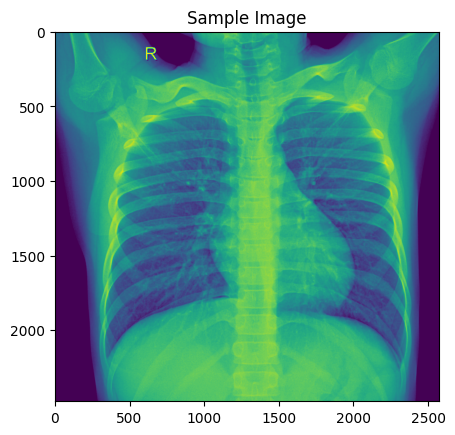

In [14]:

  img = mpimg.imread(image_path)

  plt.imshow(img)
  plt.title('Sample Image')
  plt.show()



## Pneumonia Image sample

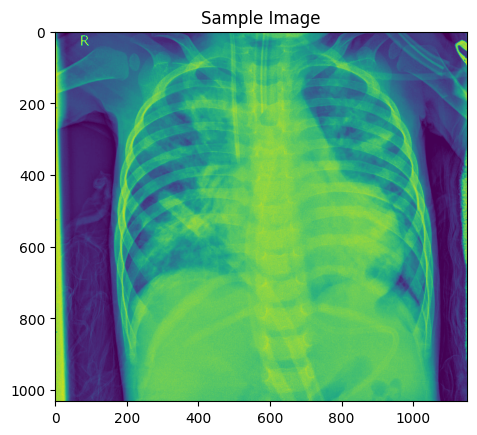

In [15]:
image_path2 = '/content/chest_xray/train/PNEUMONIA/BACTERIA-1008087-0001.jpeg'

img = mpimg.imread(image_path2)

plt.imshow(img)
plt.title('Sample Image')
plt.show()


In [16]:
img.shape


(1032, 1152)

# Converting Image size 224 to 224

In [17]:
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'

In [18]:
target_size = (224, 224)

In [19]:
from PIL import Image
import os


def resize_images(directory):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpeg'):
                image_path = os.path.join(label_dir, filename)
                image = Image.open(image_path)
                resized_image = image.resize(target_size, Image.ANTIALIAS)
                resized_image.save(image_path)

resize_images(train_dir)
resize_images(test_dir)

<ipython-input-19-423eb9b6ddf7>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


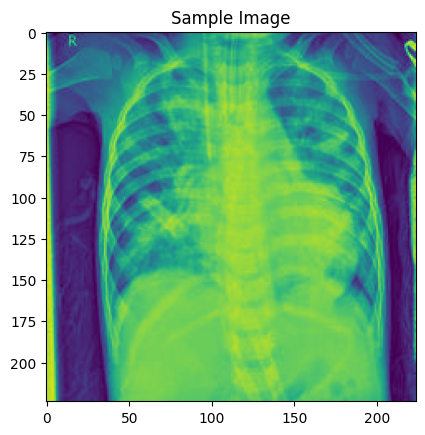

In [20]:
image_path2 = '/content/chest_xray/train/PNEUMONIA/BACTERIA-1008087-0001.jpeg'

img = mpimg.imread(image_path2)

plt.imshow(img)
plt.title('Sample Image')
plt.show()


In [21]:
img.shape

(224, 224)

# Data Framing


In [22]:
train_data = []
test_data = []

def get_data(directory):
    """
    Get image data from the specified directory.

    Args:
    - directory (str): Path to the directory containing the image data.

    Returns:
    - data (list): List of dictionaries, each containing the label and path of an image.
    """
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpeg'):
                image_path = os.path.join(label_dir, filename)
                data.append({'label': label, 'path': image_path})
    return data

import pandas as pd

# Retrieve image data from the train and test directories
train_df = pd.DataFrame(get_data(train_dir))  # Create a DataFrame for the train data
test_df = pd.DataFrame(get_data(test_dir))  # Create a DataFrame for the test data


In [23]:
train_df.head()

,label,path
0,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/VIRUS-6939...
1,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/BACTERIA-5...
2,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/BACTERIA-3...
3,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/VIRUS-6541...
4,PNEUMONIA,/content/chest_xray/train/PNEUMONIA/VIRUS-4170...


In [24]:
test_df.head()

,label,path
0,PNEUMONIA,/content/chest_xray/test/PNEUMONIA/BACTERIA-54...
1,PNEUMONIA,/content/chest_xray/test/PNEUMONIA/BACTERIA-40...
2,PNEUMONIA,/content/chest_xray/test/PNEUMONIA/VIRUS-70145...
3,PNEUMONIA,/content/chest_xray/test/PNEUMONIA/BACTERIA-72...
4,PNEUMONIA,/content/chest_xray/test/PNEUMONIA/VIRUS-11422...


In [25]:
train_df['label'].unique()
train_df.shape

(5232, 2)

In [26]:
test_df['label'].unique()
test_df.shape

(624, 2)

# DATA MODELLING

In [28]:
img_width, img_height = 224, 224  # Define the dimensions for resizing images
batch_size = 128  # Set the batch size for training
y_col = 'label'  # Specify the column containing labels in the DataFrame
x_col = 'path'  # Specify the column containing image file paths in the DataFrame
no_of_classes = len(train_df[y_col].unique())  # Calculate the number of unique classes in the training data
no_of_classes


2

In [29]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/train",  # Path to the directory containing training images
    image_size=(img_height, img_width),  # Size to which images will be resized
    batch_size=batch_size,  # Number of samples per batch
    label_mode="categorical"  # Type of labels returned (categorical for one-hot encoding)
)


Found 5232 files belonging to 2 classes.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/chest_xray/test",  # Path to the directory containing validation/test images
    image_size=(img_height, img_width),  # Size to which images will be resized
    batch_size=batch_size,  # Number of samples per batch
    label_mode="categorical"  # Type of labels returned (categorical for one-hot encoding)
)


Found 624 files belonging to 2 classes.


# Apply VGG Model

In [31]:
# Immutable base model
base_model = VGG16(
    weights="imagenet",  # Pre-trained weights to initialize the model
    include_top=False,  # Exclude the fully connected layers at the top
    input_shape=(224, 224, 3)  # Shape of input images
)

# Set the base model to be non-trainable (immutable)
base_model.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [32]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01),activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
# dense_layer_2 = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01),activation='relu')
# dense_layer_3 = layers.Dense(264, kernel_regularizer=regularizers.l2(0.01),activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    # dense_layer_2,
    # dense_layer_3,
    prediction_layer
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27561282 (105.14 MB)
Trainable params: 12846594 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# For Epoch = 4


In [34]:
classes = 2
epochs = 4
learning_rate = 0.001

adam = Adam(learning_rate=learning_rate)

In [35]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds,shuffle=True)

Epoch 1/4
41/41 [==============================] - 62s 972ms/step - loss: 20.3855 - accuracy: 0.8909 - val_loss: 7.0328 - val_accuracy: 0.8013
Epoch 2/4
41/41 [==============================] - 23s 545ms/step - loss: 4.6640 - accuracy: 0.9472 - val_loss: 4.5042 - val_accuracy: 0.8734
Epoch 3/4
41/41 [==============================] - 25s 555ms/step - loss: 3.4929 - accuracy: 0.9709 - val_loss: 3.5794 - val_accuracy: 0.8718
Epoch 4/4
41/41 [==============================] - 26s 616ms/step - loss: 2.7632 - accuracy: 0.9761 - val_loss: 3.1149 - val_accuracy: 0.8462


In [37]:

print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [38]:
test_loss, test_accuracy = model.evaluate(val_ds)

5/5 [==============================] - 3s 459ms/step - loss: 3.1149 - accuracy: 0.8462


In [39]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

Test Loss: 3.114861011505127, Test Accuracy: 84.61538553237915%


# For epoch = 8

In [44]:
classes = 2
epochs = 8
learning_rate = 0.001

adam = Adam(learning_rate=learning_rate)

In [45]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds,shuffle=True)

Epoch 1/8
41/41 [==============================] - 68s 551ms/step - loss: 6.7491 - accuracy: 0.9398 - val_loss: 24.0217 - val_accuracy: 0.8494
Epoch 2/8
41/41 [==============================] - 23s 545ms/step - loss: 2.2293 - accuracy: 0.9801 - val_loss: 9.5142 - val_accuracy: 0.8894
Epoch 3/8
41/41 [==============================] - 23s 543ms/step - loss: 1.2649 - accuracy: 0.9897 - val_loss: 9.0012 - val_accuracy: 0.8654
Epoch 4/8
41/41 [==============================] - 23s 553ms/step - loss: 0.9598 - accuracy: 0.9925 - val_loss: 6.1515 - val_accuracy: 0.8878
Epoch 5/8
41/41 [==============================] - 23s 549ms/step - loss: 0.7306 - accuracy: 0.9954 - val_loss: 5.4395 - val_accuracy: 0.8878
Epoch 6/8
41/41 [==============================] - 24s 566ms/step - loss: 0.6491 - accuracy: 0.9925 - val_loss: 4.1576 - val_accuracy: 0.8782
Epoch 7/8
41/41 [==============================] - 26s 629ms/step - loss: 0.5647 - accuracy: 0.9937 - val_loss: 3.1372 - val_accuracy: 0.9022
Epoch

In [47]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [48]:
test_loss, test_accuracy = model.evaluate(val_ds)

5/5 [==============================] - 3s 495ms/step - loss: 3.2844 - accuracy: 0.8718


In [49]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

Test Loss: 3.284400463104248, Test Accuracy: 87.17948794364929%


# For Epoch 12

In [50]:
classes = 2
epochs = 12
learning_rate = 0.001 # model parameter rate

adam = Adam(learning_rate=learning_rate)

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [52]:
history = model.fit(
    train_ds,  # Training dataset
    epochs=epochs,  # Number of epochs for training
    verbose=1,  # Verbosity mode: 1 for progress bar, 0 for silent, 2 for one line per epoch
    validation_data=val_ds,  # Validation dataset for evaluation
    shuffle=True  # Shuffle the training data before each epoch
)


Epoch 1/12
41/41 [==============================] - 25s 538ms/step - loss: 3.6843 - accuracy: 0.9507 - val_loss: 19.6836 - val_accuracy: 0.8141
Epoch 2/12
41/41 [==============================] - 23s 547ms/step - loss: 1.5771 - accuracy: 0.9815 - val_loss: 8.5063 - val_accuracy: 0.8542
Epoch 3/12
41/41 [==============================] - 23s 558ms/step - loss: 0.9414 - accuracy: 0.9899 - val_loss: 5.4288 - val_accuracy: 0.8798
Epoch 4/12
41/41 [==============================] - 24s 570ms/step - loss: 0.7167 - accuracy: 0.9920 - val_loss: 3.2735 - val_accuracy: 0.8510
Epoch 5/12
41/41 [==============================] - 24s 576ms/step - loss: 0.5365 - accuracy: 0.9924 - val_loss: 1.8581 - val_accuracy: 0.8526
Epoch 6/12
41/41 [==============================] - 24s 567ms/step - loss: 0.4445 - accuracy: 0.9912 - val_loss: 2.2814 - val_accuracy: 0.8830
Epoch 7/12
41/41 [==============================] - 24s 584ms/step - loss: 0.3874 - accuracy: 0.9908 - val_loss: 2.1472 - val_accuracy: 0.883

In [53]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [54]:
test_loss, test_accuracy = model.evaluate(val_ds)
# to compute the loss and accuracy metrics

5/5 [==============================] - 3s 471ms/step - loss: 0.9477 - accuracy: 0.9103


In [55]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

Test Loss: 0.9476994276046753, Test Accuracy: 91.02563858032227%


#Plotting Accuracy

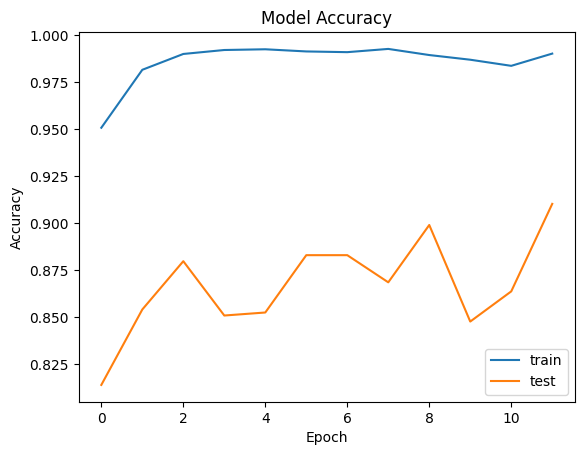

In [56]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Testing

## For Testing Normal image

In [61]:
img = cv2.imread("/content/chest_xray/test/NORMAL/NORMAL-1228182-0001.jpeg")
img = np.expand_dims(img, 0)

In [62]:
pred = model.predict(img)

1/1 [==============================] - 0s 35ms/step


In [63]:

train_ds.class_names[np.argmax(pred[0])]

'NORMAL'

## For Testing Pneumonia image

In [67]:
img = cv2.imread("/content/chest_xray/test/PNEUMONIA/BACTERIA-1714895-0001.jpeg")
img = np.expand_dims(img, 0)

In [68]:
pred = model.predict(img)

1/1 [==============================] - 0s 31ms/step


In [69]:
train_ds.class_names[np.argmax(pred[0])]

'PNEUMONIA'

In [70]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing for Randoms

1/1 [==============================] - 0s 24ms/step


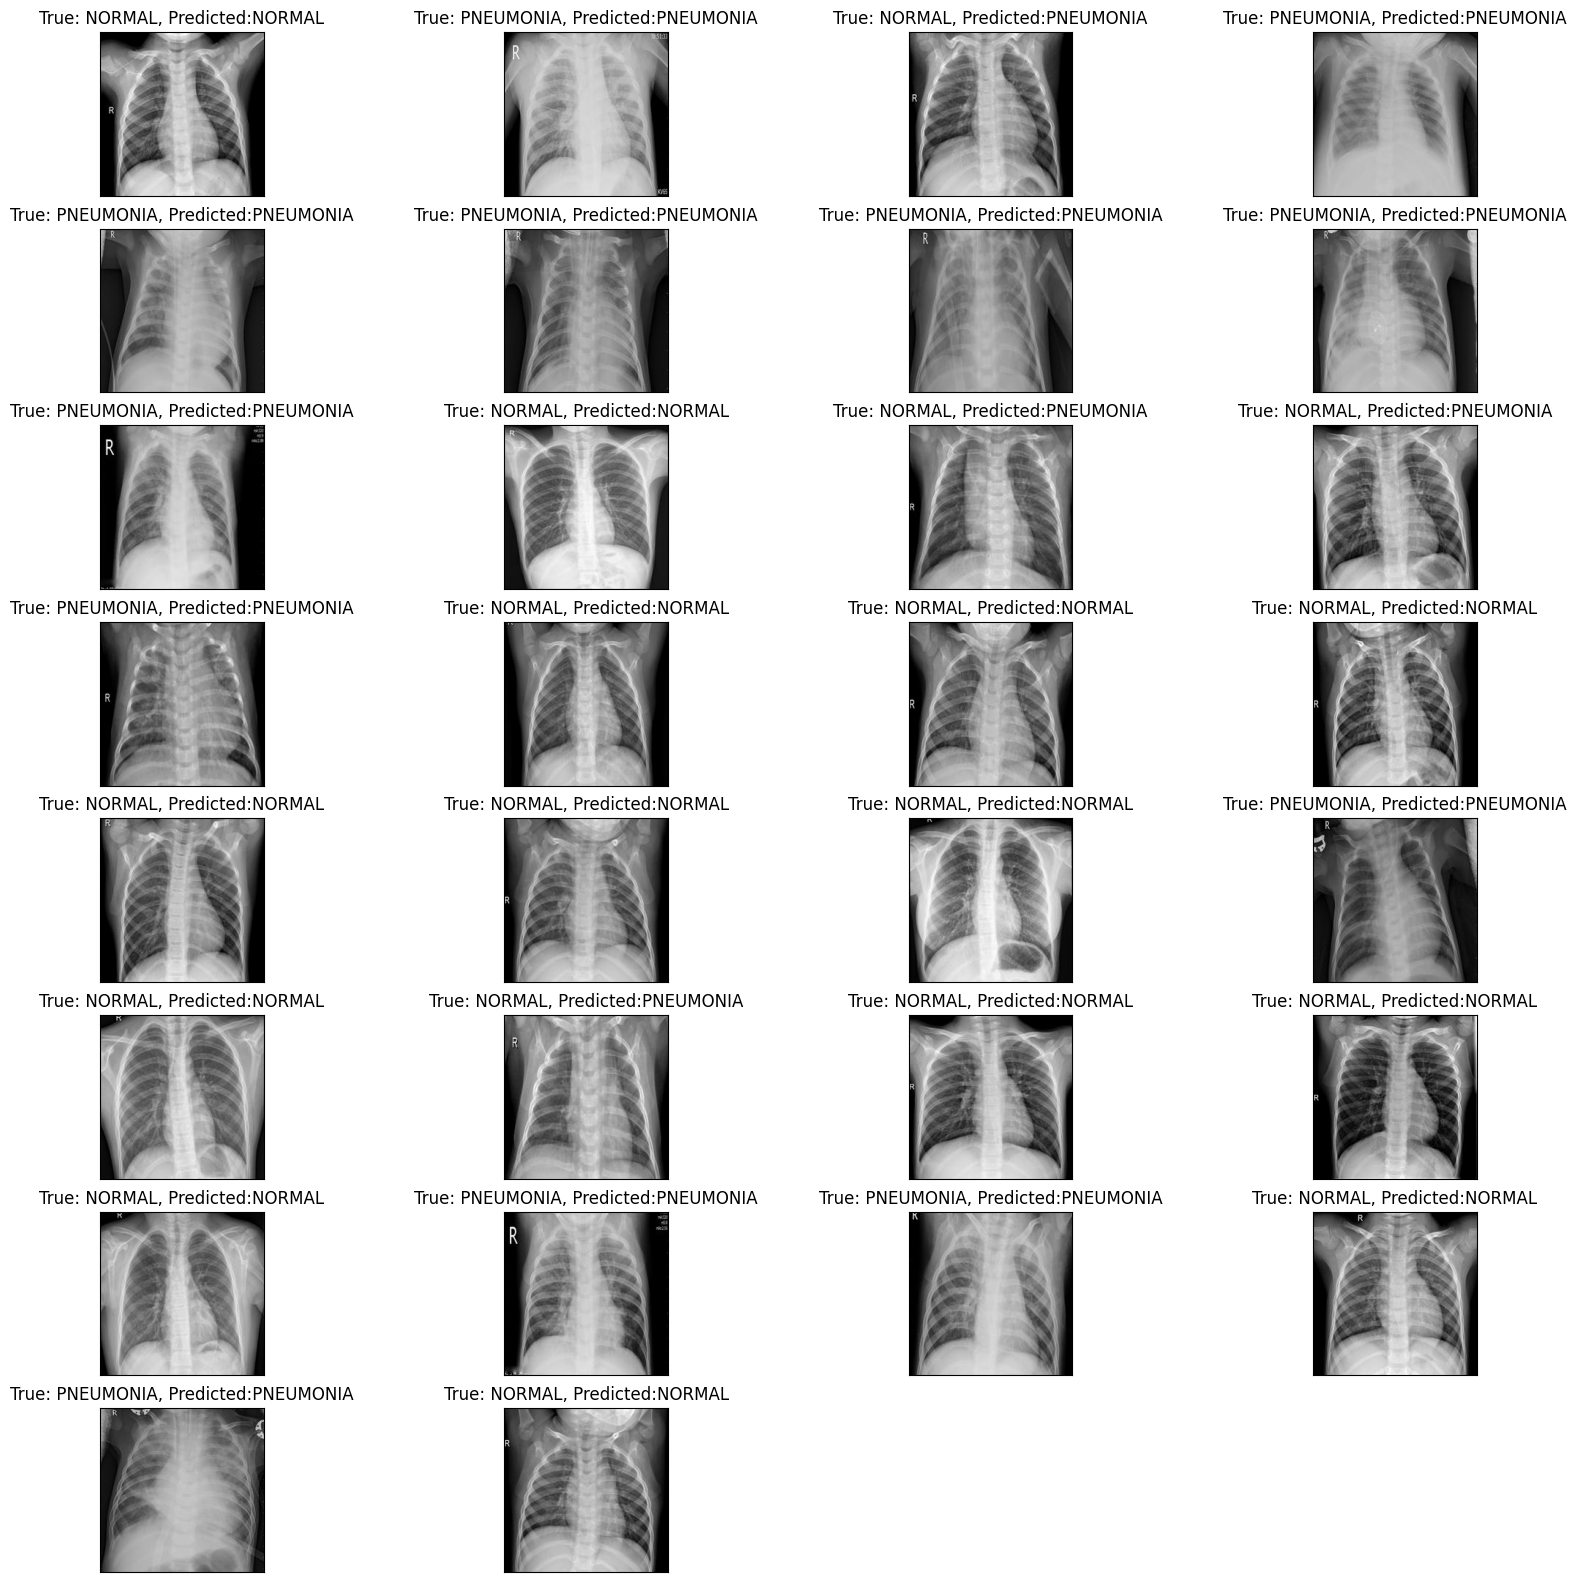

In [71]:
prefix = "/content/chest_xray/test"  # Prefix for the test directory containing class subdirectories

classes = os.listdir(prefix)  # List of class names (subdirectories) in the test directory

choices = []  # List to store randomly selected image paths and their corresponding labels

# Loop to randomly select images from different classes
for i in range(6):
    temp = {}  # Dictionary to store image paths and labels for each selection
    for j in range(5):
        ch = random.choice(classes)  # Randomly select a class
        li = os.listdir(prefix + "/" + ch)  # List files in the selected class directory
        file_ = prefix + "/" + ch + "/" + random.choice(li)  # Randomly select an image file
        temp[file_] = ch  # Add the selected image path and its label to the dictionary
    choices.append(temp)  # Add the dictionary to the choices list

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 20))  # Set the size of the plot

n = 4  # Number of columns in the plot grid
im = 8  # Number of rows in the plot grid
ct = 1  # Counter for subplot indexing

# Loop to plot selected images with their true and predicted labels
for row in choices:
    for i in row:
        ax = plt.subplot(im, n, ct)  # Create a subplot
        ct = ct + 1  # Increment counter
        image = cv2.imread(i)  # Read the image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR image to RGB
        plt.imshow(image)  # Display the image
        image = np.expand_dims(image, 0)  # Add a batch dimension
        ax.get_xaxis().set_visible(False)  # Hide x-axis
        ax.get_yaxis().set_visible(False)  # Hide y-axis
        # Set title with true and predicted labels
        ax.set_title("True: {}, Predicted:{}".format(row[i], train_ds.class_names[np.argmax(model.predict(image)[0])]))

plt.show()  # Show the plot


# Loading Model

In [74]:
from tensorflow import keras
model = keras.models.load_model('/content/model.h5')

## Testing For Unkown Data From Internet

## Normal X ray : Image

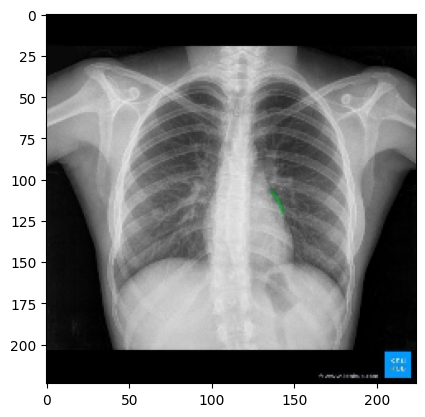

1/1 [==============================] - 0s 195ms/step
Predicted class: NORMAL


In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` and `train_ds` are defined somewhere in your code

# Read the image
img = cv2.imread("/content/chest_xray/test/Q/normal_01.jpeg")
# Convert BGR image to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Resize the image to match the model's input shape
img = cv2.resize(img, (224, 224))

# Display the image
plt.imshow(img)
plt.show()

# Add batch dimension
img = np.expand_dims(img, 0)
# Make prediction
pred = model.predict(img)
# Get the predicted class index
predicted_class_index = np.argmax(pred[0])
# Get the predicted class name using class index
predicted_class_name = train_ds.class_names[predicted_class_index]

print("Predicted class:", predicted_class_name)


## Pnemonia X ray Image

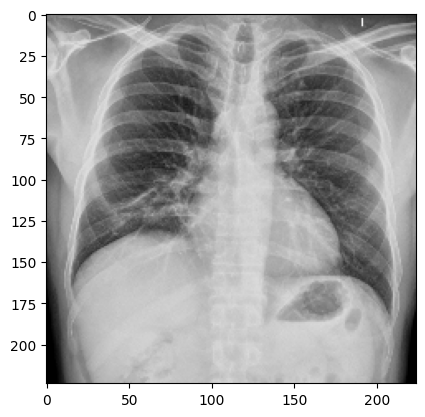

1/1 [==============================] - 0s 93ms/step
Predicted class: PNEUMONIA


In [79]:

img = cv2.imread("/content/chest_xray/test/Q/pneumonia_02.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))


plt.imshow(img)
plt.show()  # Add this to actually display the image

img = np.expand_dims(img, 0)
pred = model.predict(img)
predicted_class_index = np.argmax(pred[0])
predicted_class_name = train_ds.class_names[predicted_class_index]

print("Predicted class:", predicted_class_name)